In [1]:
from typing import Final

import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

In [2]:
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = "12"

In [3]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
provider.backends()

[<IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>]

In [4]:
backend = provider.get_backend("ibmq_qasm_simulator")
backend

<IBMBackend('ibmq_qasm_simulator')>

In [5]:
SHOTS: Final[int] = 4000

p_values = np.linspace(0, 1, 10)

qr = QuantumRegister(2, name="q")
anc = QuantumRegister(2, name="ancilla")
cr = ClassicalRegister(2, name="c")

pumps = ["ZZ", "XX", "ZZ_XX"]
states = ["00", "01", "10", "11"]
circuits = {
    pumps: {
        states: [QuantumCircuit(qr, anc, cr) for _ in range(len(p_values))]
        for states in states
    }
    for pumps in pumps
}

for pump in pumps:
    for state in states:
        for i, p in enumerate(p_values):
            if state == "00":
                pass
            elif state == "01":
                circuits[pump][state][i].x(qr[0])
            elif state == "10":
                circuits[pump][state][i].x(qr[1])
            elif state == "11":
                circuits[pump][state][i].x(qr[:])
            circuits[pump][state][i].barrier()

            circuits[pump][state][i].cx(qr[0], qr[1])

            if pump == "ZZ":
                circuits[pump][state][i].x(anc[0])
                circuits[pump][state][i].cx(qr[1], anc[0])
                circuits[pump][state][i].cry(2 * np.arcsin(np.sqrt(p)), anc[0], qr[1])
                circuits[pump][state][i].cx(qr[1], anc[0])
                circuits[pump][state][i].h(qr[0])

            elif pump == "XX":
                circuits[pump][state][i].h(qr[0])
                circuits[pump][state][i].x(anc[1])
                circuits[pump][state][i].cx(qr[0], anc[1])
                circuits[pump][state][i].cry(2 * np.arcsin(np.sqrt(p)), anc[1], qr[0])
                circuits[pump][state][i].cx(qr[0], anc[1])

            elif pump == "ZZ_XX":
                circuits[pump][state][i].x(anc[0])
                circuits[pump][state][i].cx(qr[1], anc[0])
                circuits[pump][state][i].cry(2 * np.arcsin(np.sqrt(p)), anc[0], qr[1])
                circuits[pump][state][i].cx(qr[1], anc[0])
                circuits[pump][state][i].h(qr[0])
                circuits[pump][state][i].x(anc[1])
                circuits[pump][state][i].cx(qr[0], anc[1])
                circuits[pump][state][i].cry(2 * np.arcsin(np.sqrt(p)), anc[1], qr[0])
                circuits[pump][state][i].cx(qr[0], anc[1])

            circuits[pump][state][i].barrier()

            circuits[pump][state][i].measure(qr[:], cr[:])

In [6]:
jobs = {
    pump: {
        state: execute(circuits[pump][state], backend, shots=SHOTS) for state in states
    }
    for pump in pumps
}

overlaps = {
    pumps: {state: np.zeros(len(p_values)) for state in states} for pumps in pumps
}

for pump in pumps:
    for i in range(len(p_values)):
        for state in states:
            counts = jobs[pump][state].result().get_counts(i)
            for outcome in counts:
                overlaps[pump][outcome][i] += counts[outcome] / (4 * SHOTS)

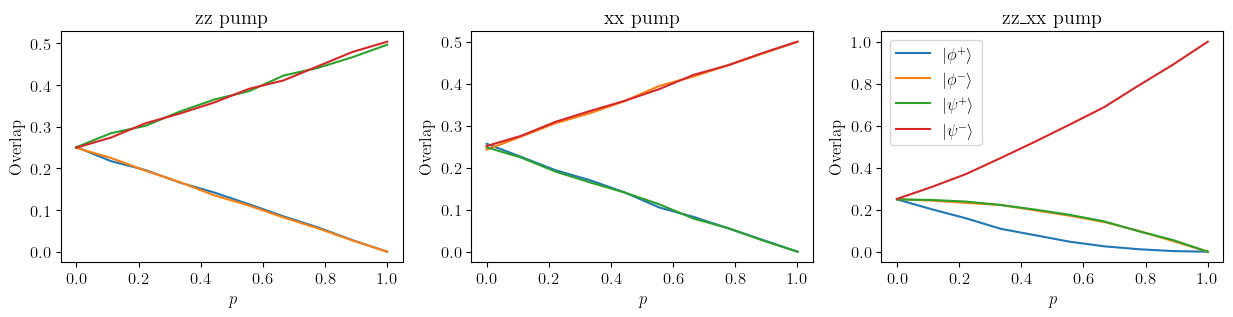

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

labels = {
    "00": r"$|\phi^{+}\rangle$",
    "01": r"$|\phi^{-}\rangle$",
    "10": r"$|\psi^{+}\rangle$",
    "11": r"$|\psi^{-}\rangle$",
}

for idx, pump in enumerate(pumps):
    for outcome in overlaps[pump]:
        ax[idx].plot(p_values, overlaps[pump][outcome], label=labels[outcome])

    ax[idx].set_title(r"$\textrm{" + pump.lower() + r" pump}$")

    ax[idx].set_xlabel(r"$p$")
    ax[idx].set_ylabel(r"$\textrm{Overlap}$")
ax[-1].legend()


In [8]:
import qiskit.tools.jupyter

%qiskit_version_table